In [1]:
import multiprocessing
import locale
import os
import time
from random import randint
from random import random

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import matplotlib.pyplot as plt
import numpy as np
import pyreadr

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange, tqdm

from models.autoencoder import Autoencoder
from data.PERMAD_data_reader import PermadData

locale.getpreferredencoding = lambda: "UTF-8"
param_path = "models/meta_parameters/"

# Use GPU: Send Tensors .to(device)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print("Device: ", device)

Device:  cpu


In [2]:
#model = Autoencoder(features=98, layers=[64, 32, 16], dropout=0.0)
model_h = Autoencoder(features=98, layers=[16, 4], dropout=0.0)
model_s = Autoencoder(features=98, layers=[16, 4], dropout=0.0)
model_h.load_state_dict(torch.load(os.path.join(param_path,"autoencoder_param_healthy.pt")))
model_s.load_state_dict(torch.load(os.path.join(param_path,"autoencoder_param_sick.pt")))

data_subjects = PermadData().data_subjects
time_data = PermadData().time_data.to_numpy()
time_id_subjects = PermadData().time_id_subjects

In [3]:
class SubjectData(Dataset):
  def __init__(self, data_subjects):
     #self.data = [subject[:,1:-1] for subject in data_subjects]
     self.data = data_subjects
      
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]
  
subject_ds = SubjectData(data_subjects)

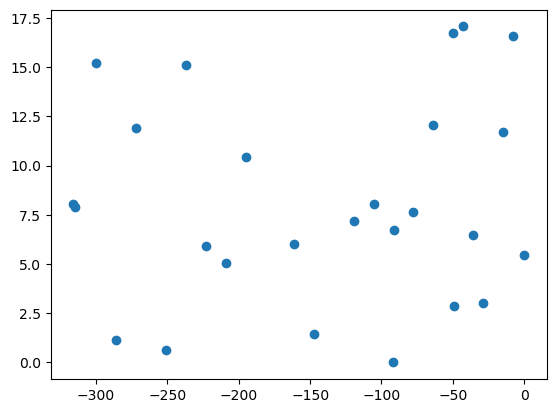

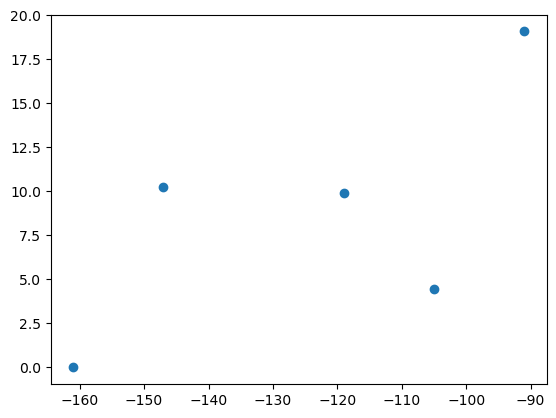

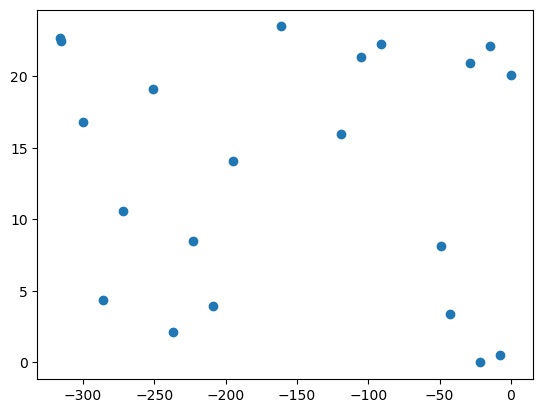

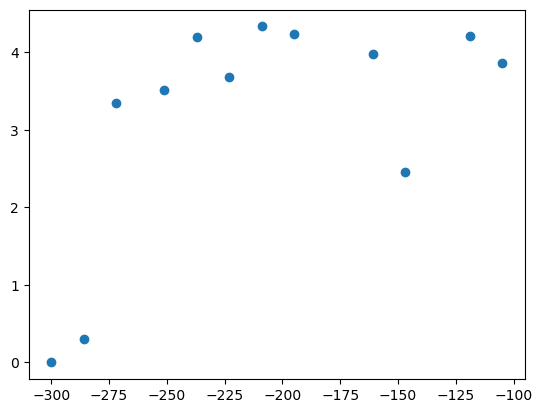

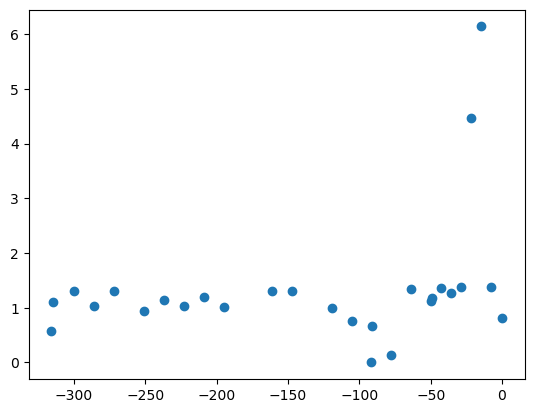

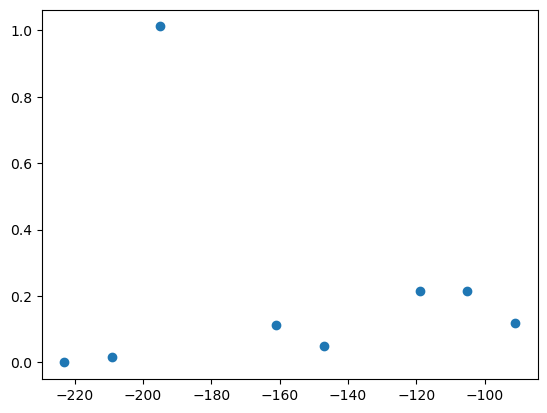

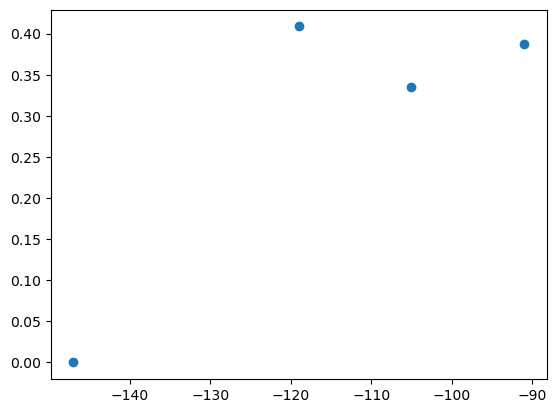

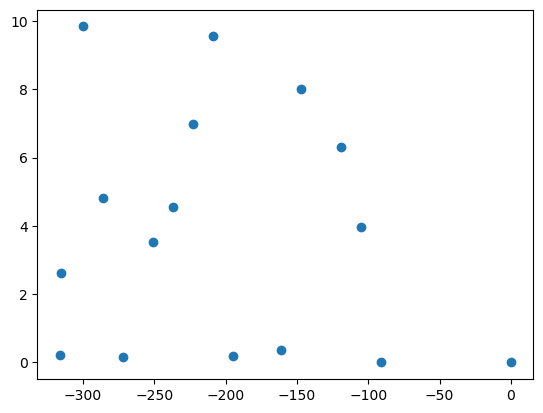

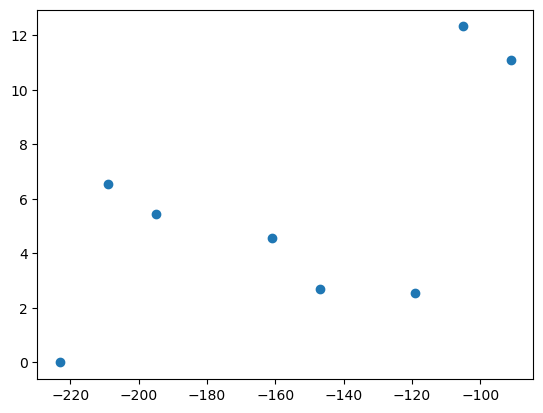

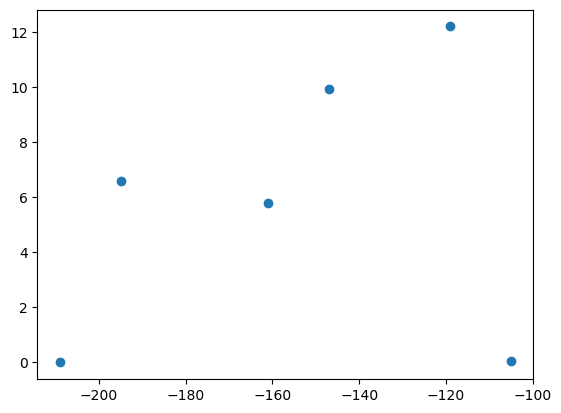

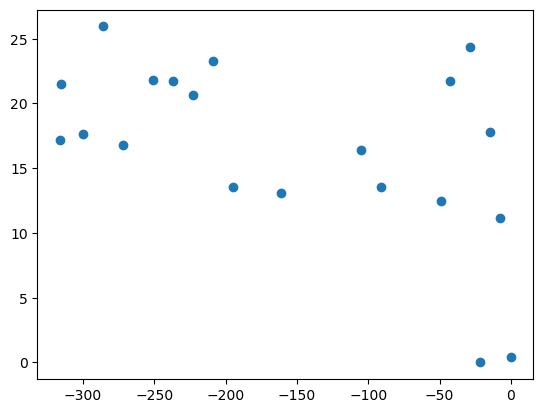

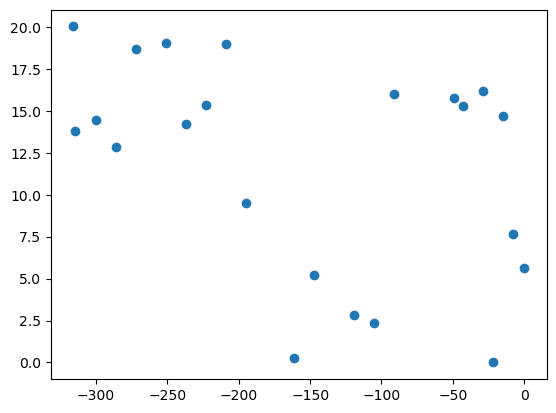

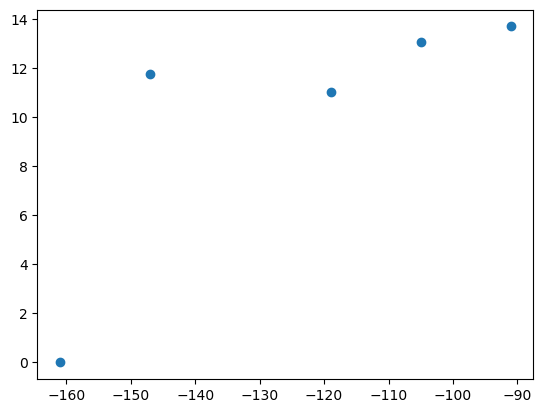

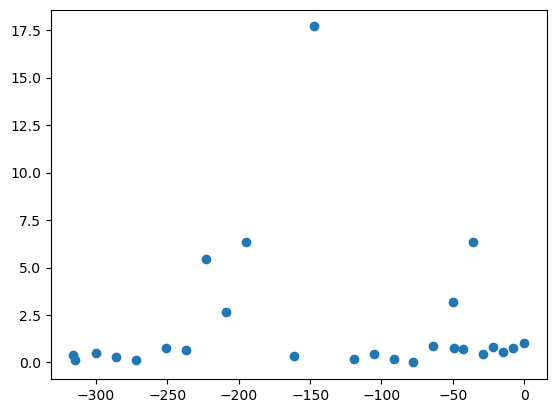

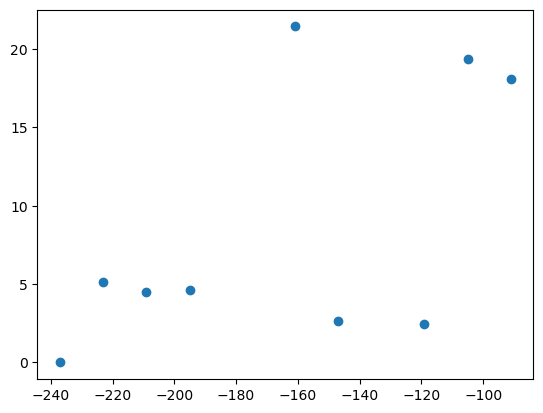

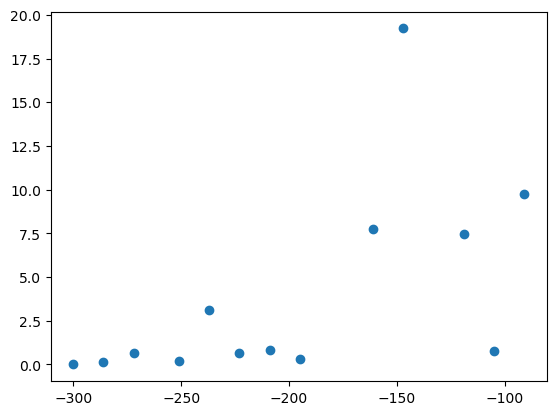

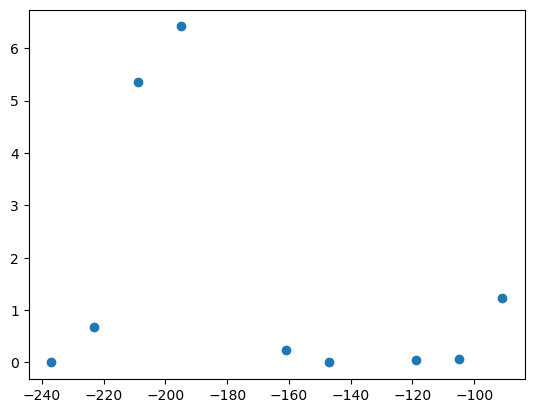

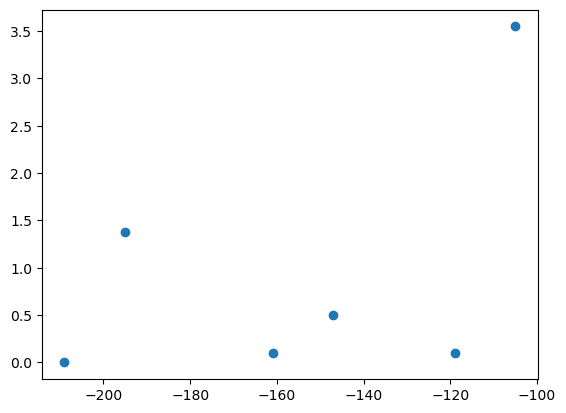

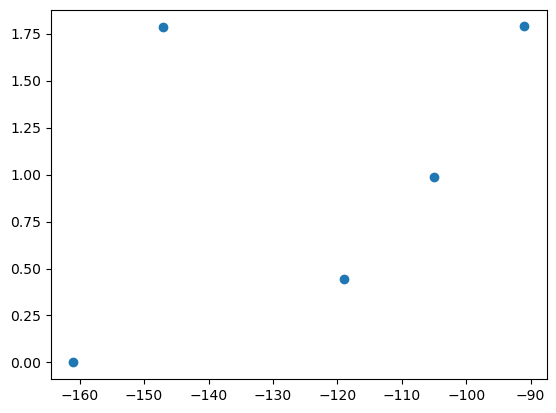

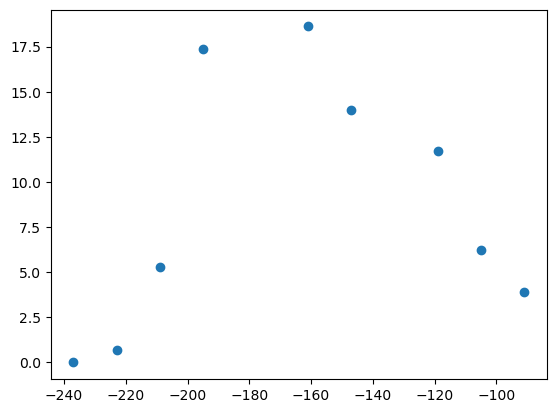

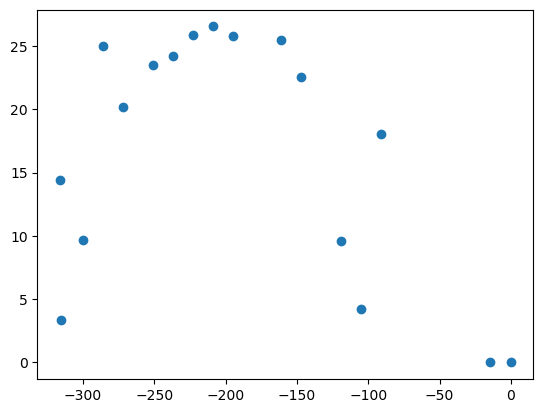

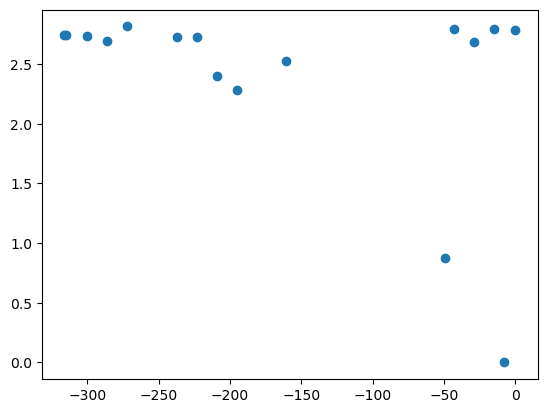

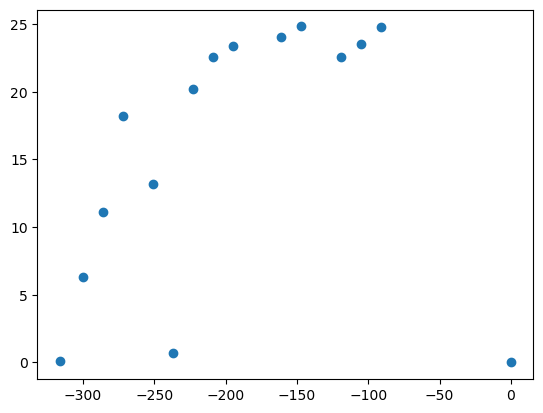

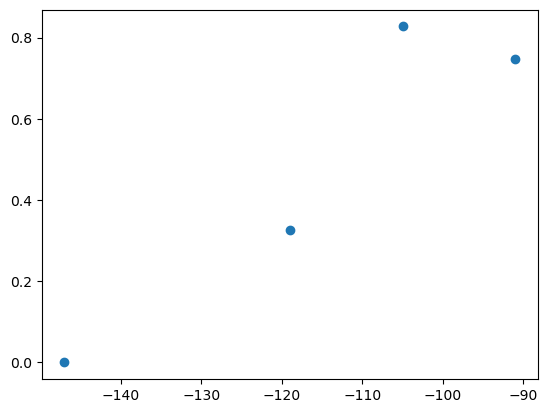

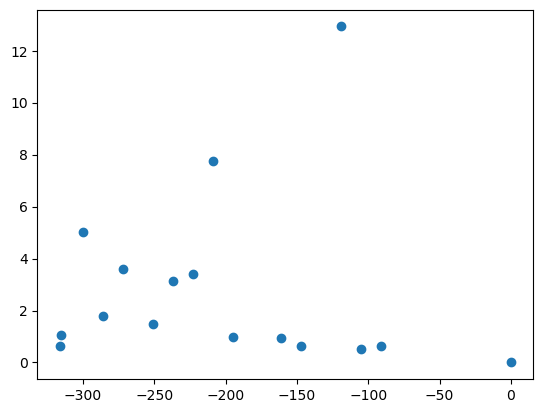

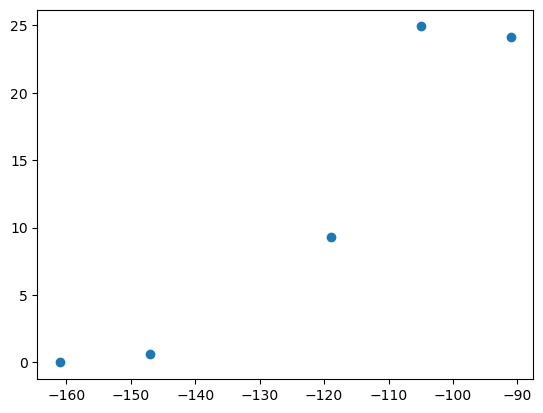

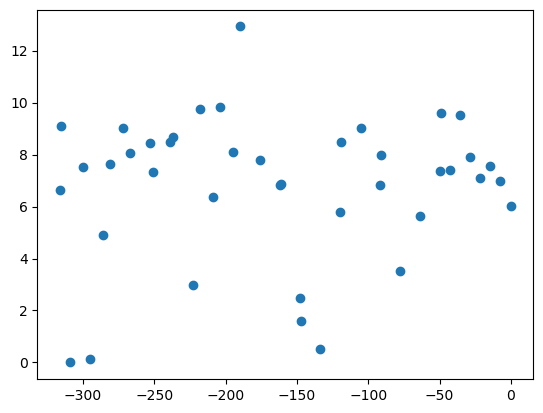

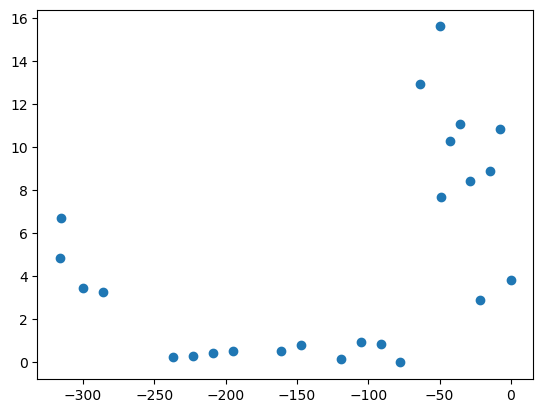

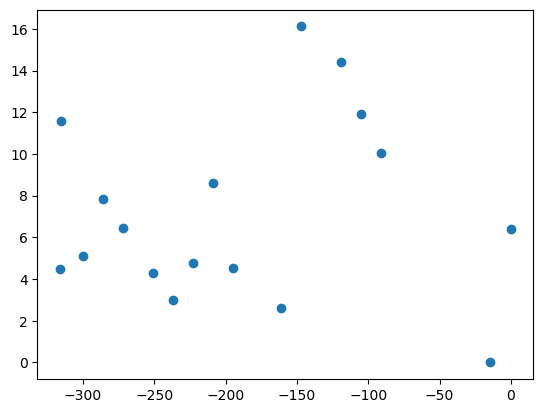

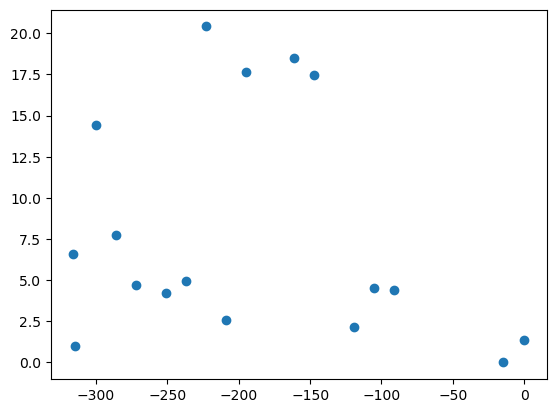

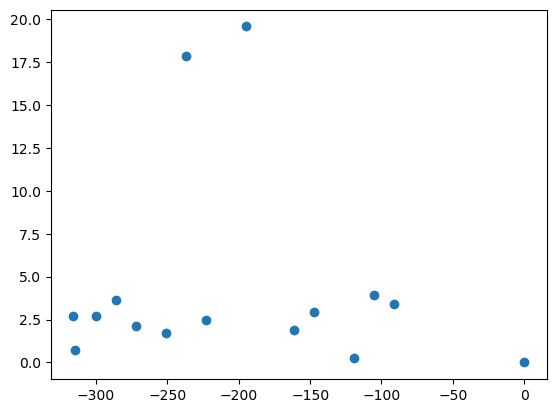

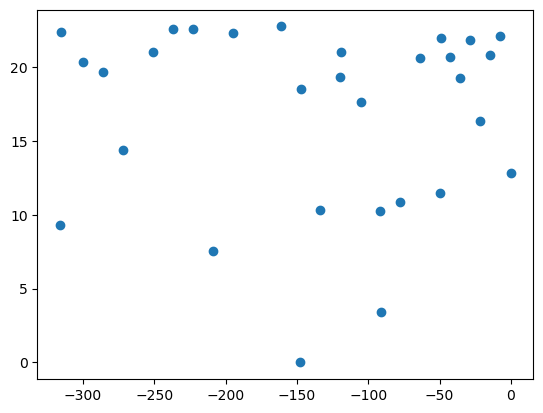

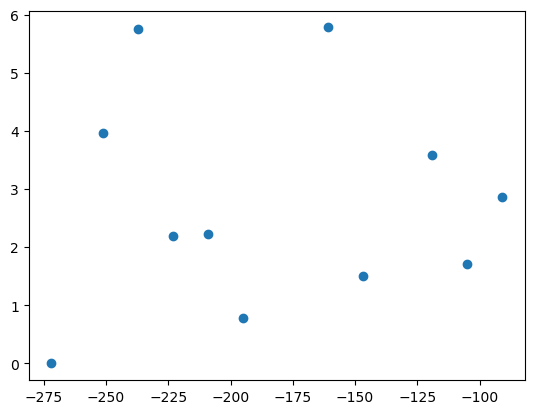

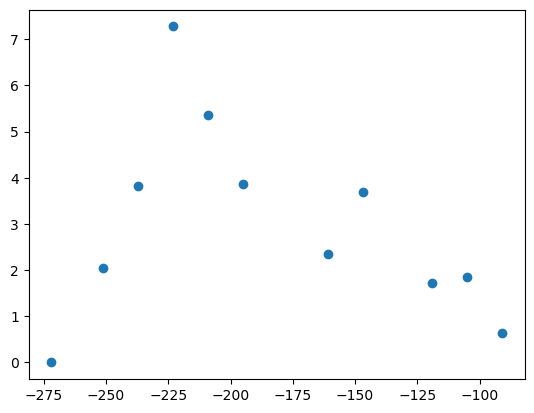

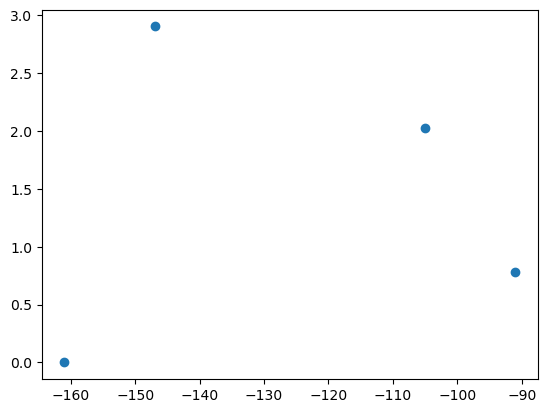

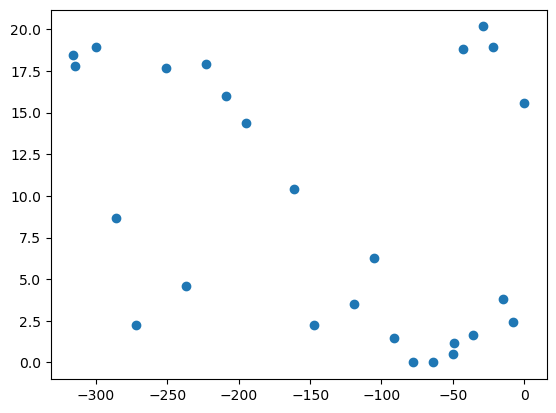

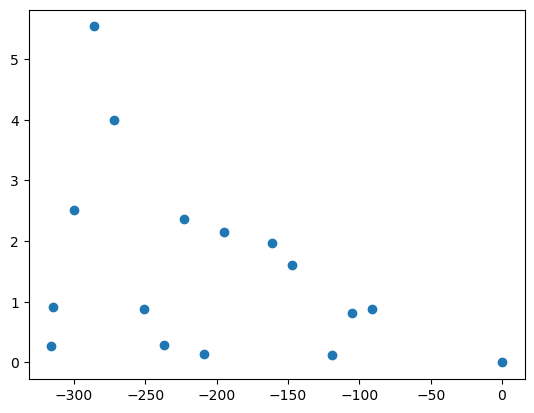

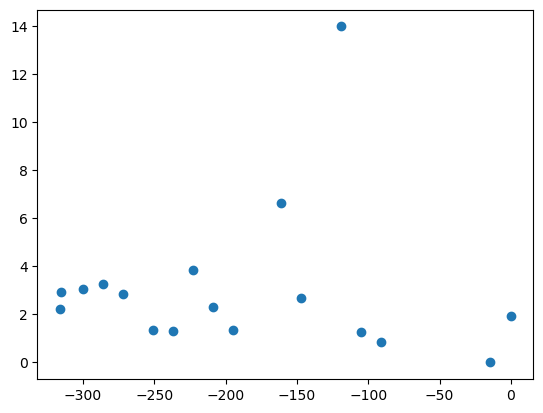

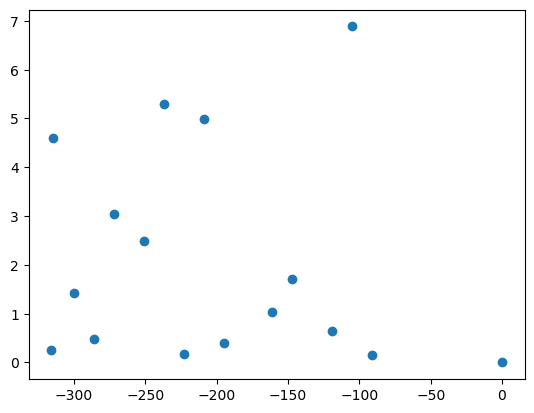

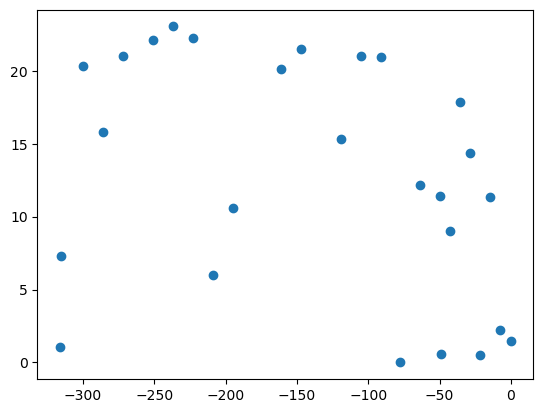

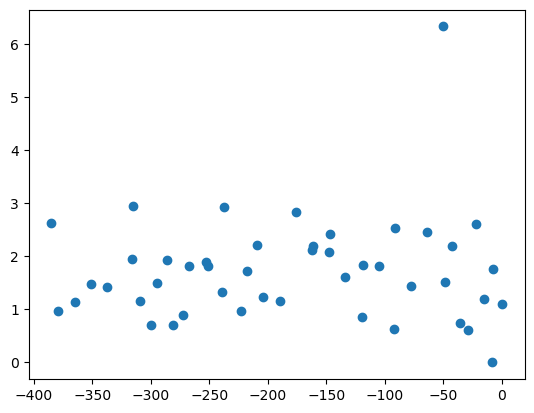

In [7]:
def conformity_score(data, subject_idx):
    """
    compare healthy embedding with test point embedding
    """
    s = subject_ds[subject_idx]
    embedding_healthy = model_h.encoder(torch.tensor(s[:,0]).to(torch.float))
    embedding_sick = model_s.encoder(torch.tensor(s[:,-1]).to(torch.float))
    embeddings_healthy = [model_h.encoder(torch.tensor(s[:,t]).to(torch.float)) for t in range(0, s.shape[1])]
    embeddings_sick = [model_s.encoder(torch.tensor(s[:,t]).to(torch.float)) for t in range(0, s.shape[1])]
    euclid_dis = lambda x, y : torch.cdist(torch.unsqueeze(x,0), torch.unsqueeze(y,0)).item()
    l1_dis = lambda x, y : torch.cdist(torch.unsqueeze(x,0), torch.unsqueeze(y,0), p=1).item()
    diff_dis = lambda x,y : torch.sum(torch.unsqueeze(x,0), torch.unsqueeze(y,0)).item()
    scores_healthy = [l1_dis(embedding_healthy,t) for t in embeddings_healthy] 
    scores_sick = [l1_dis(embedding_sick,t) for t in embeddings_sick] 
    return scores_healthy, scores_sick


def conformity_score_2(data, subject_idx):
    """
    compare mse between model and testpoint
    """
    s = subject_ds[subject_idx]
    pred_h = [model_h(torch.tensor(s[:,t]).to(torch.float)) for t in range(0, s.shape[1])]
    #pred = np.array(list(map(lambda x : x.detach().numpy(), pred_healthy))).T

    criterion = nn.MSELoss()
    msd_loss = lambda x,y : criterion(torch.tensor(x).to(torch.float), y.clone().detach().to(torch.float))
    scores_h = [msd_loss(s[:,i],pred_h[i]) for i in range(0, len(pred_h))] 
    return scores_h, None


def plot_scores(subject_ds, subject_idx):
    scores_h, scores_s =  conformity_score(subject_ds, subject_idx)
    scores = np.array(scores_h)
    #scores = np.array(scores_s) 
    # get time points
    time_id_subjects[subject_idx].to_numpy()
    time_points = [time_data[int(t.item())-1].item() for t in time_id_subjects[subject_idx].to_numpy()]
    plt.scatter(time_points, scores)
    #plt.scatter(range(0, len(scores)), scores)
    plt.show()
    
for i in range(0, len(subject_ds)):
    plot_scores(subject_ds, i)

In [8]:
def conformal_p_value(a_n, Z):
    """
    compute the conformal p-value for a_n
    :param a_n: conformity score for point x_n
    :param Z: list of all conformity scores a_1 ... a_n
    :return: p_n
    """
    num_ai_l_an = np.count_nonzero(Z < a_n)
    num_ai_eq_an = np.count_nonzero(Z == a_n)
    theta = random()
    n = len(Z)
    return (num_ai_l_an + theta * num_ai_eq_an)/n

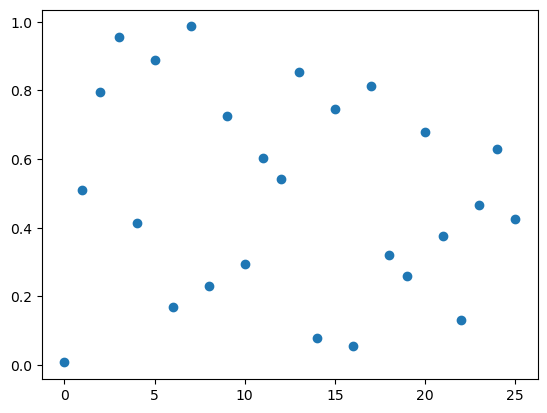

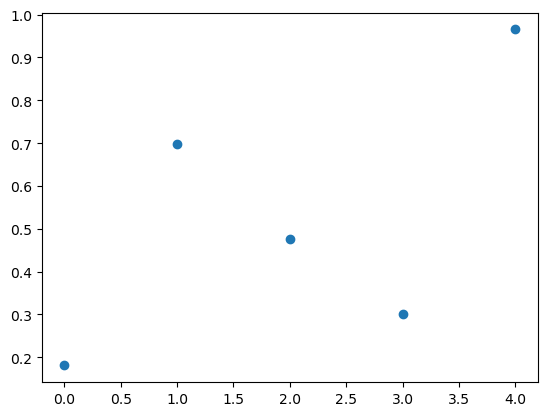

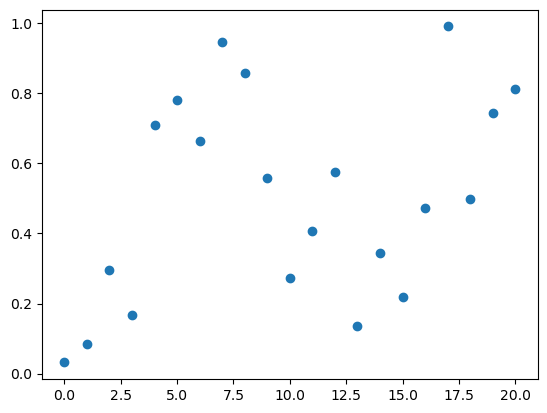

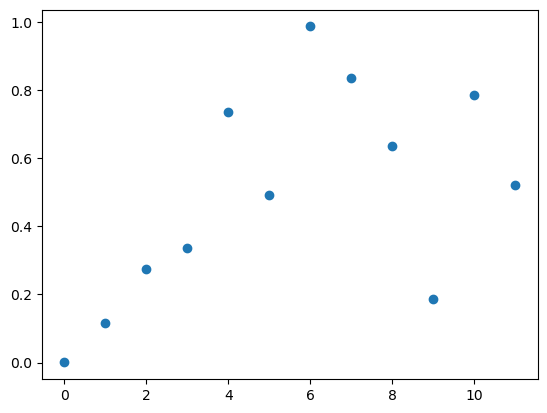

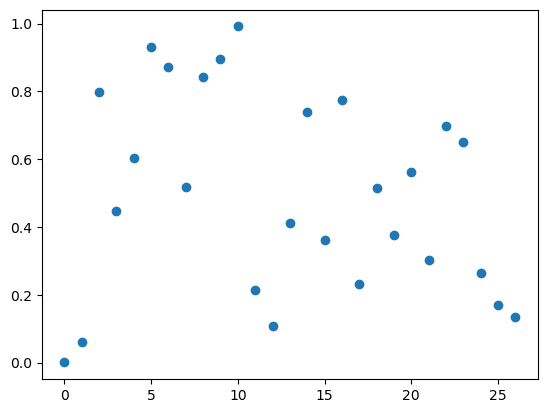

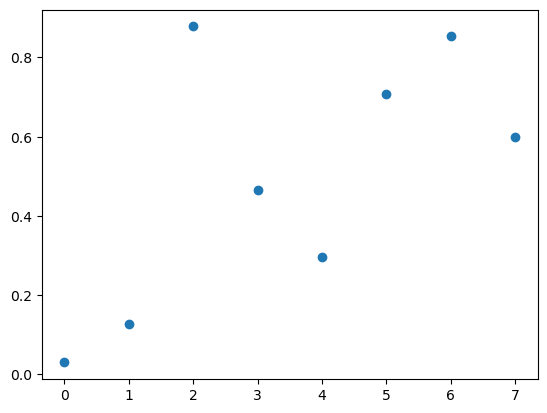

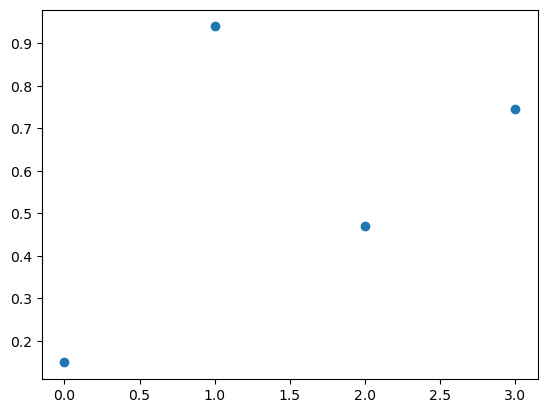

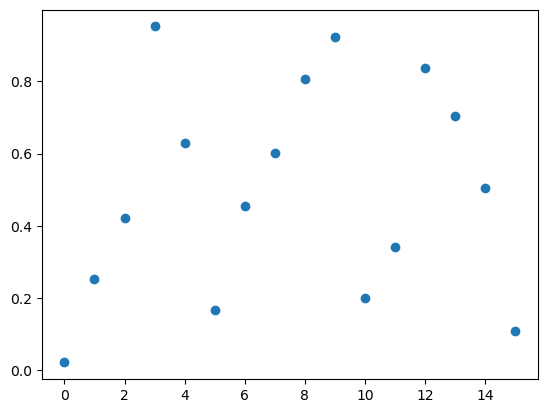

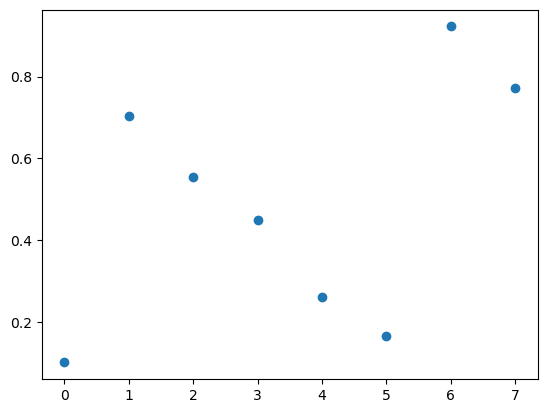

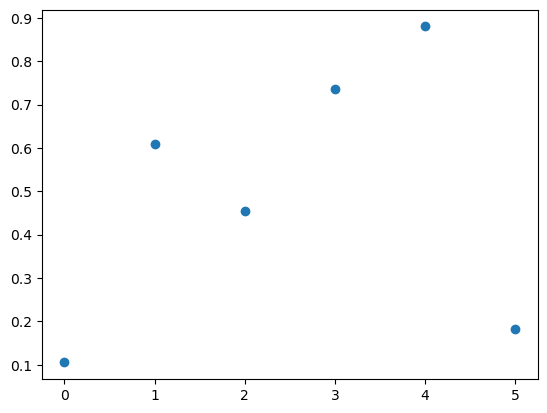

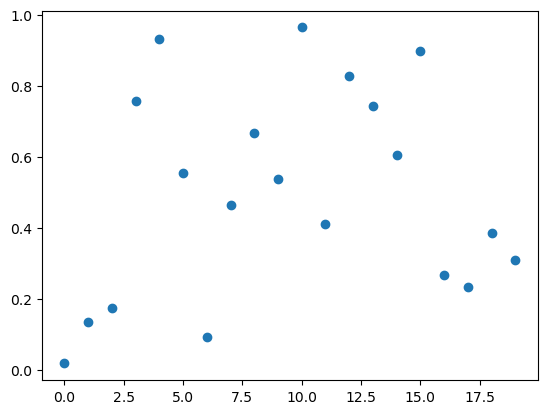

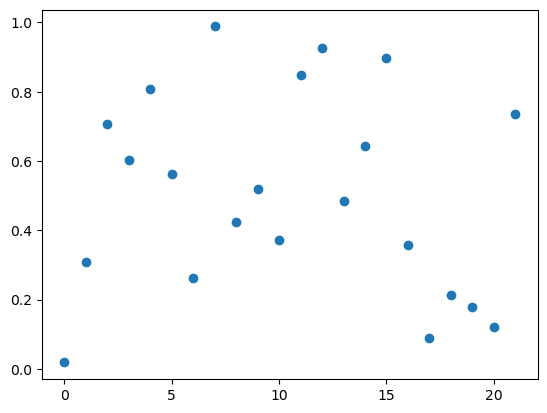

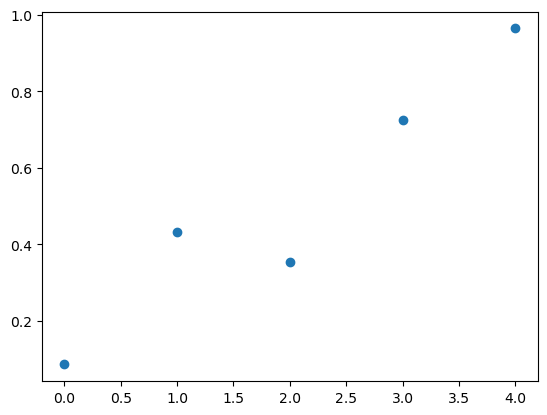

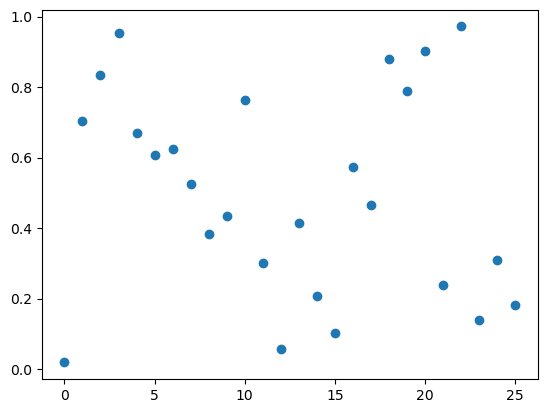

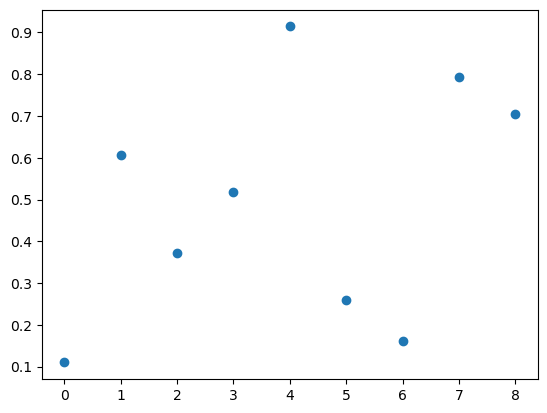

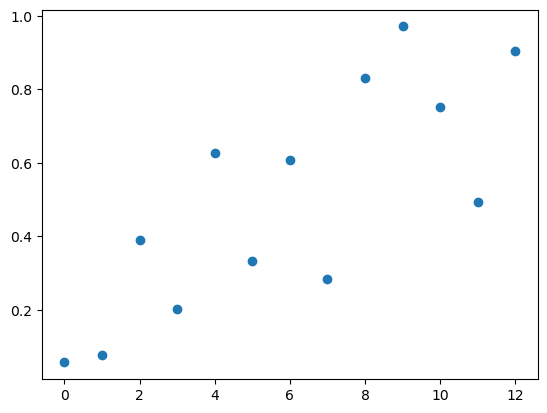

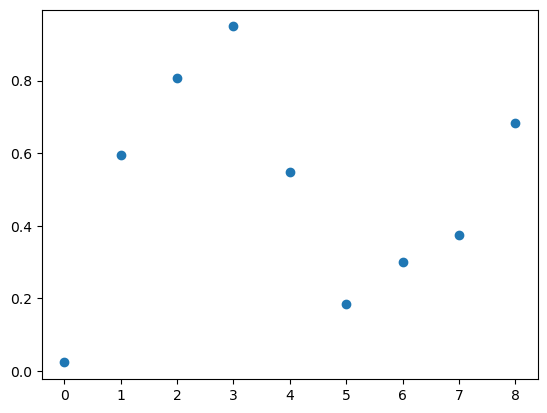

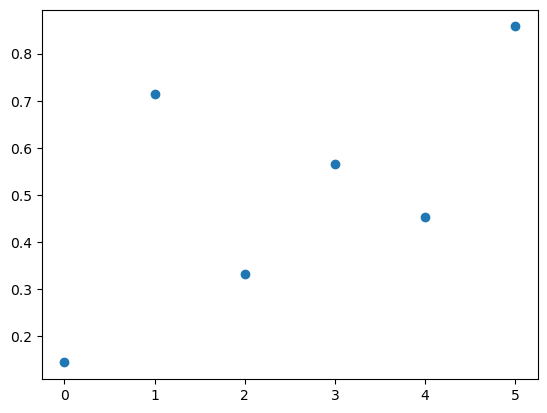

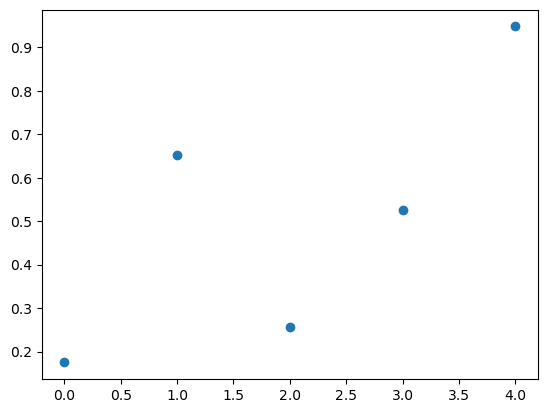

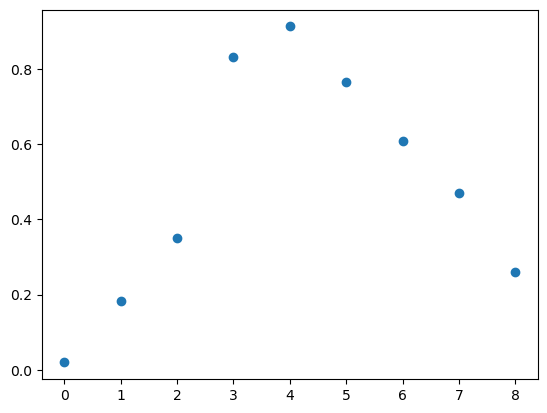

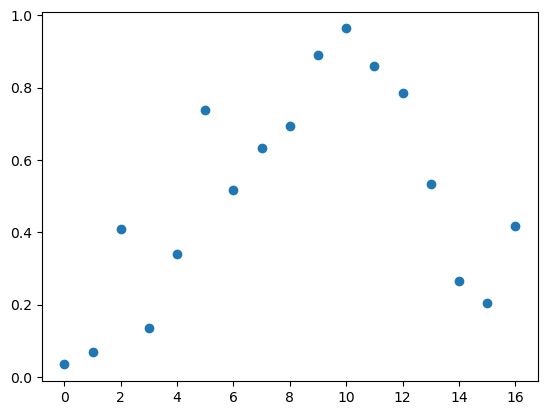

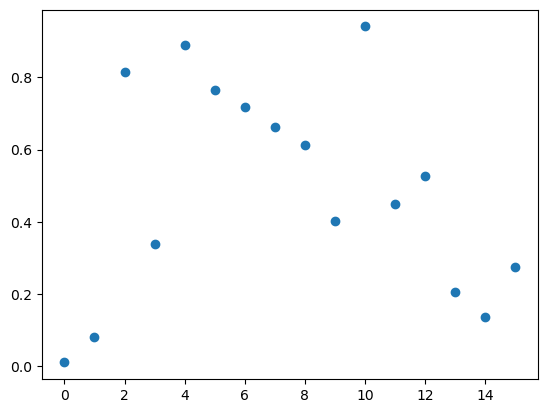

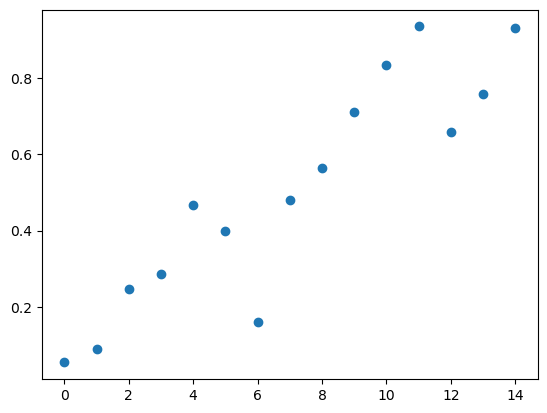

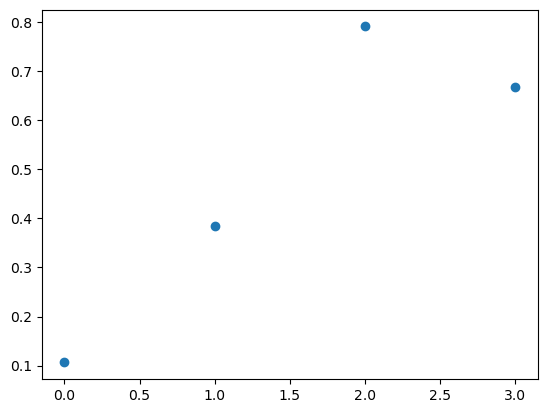

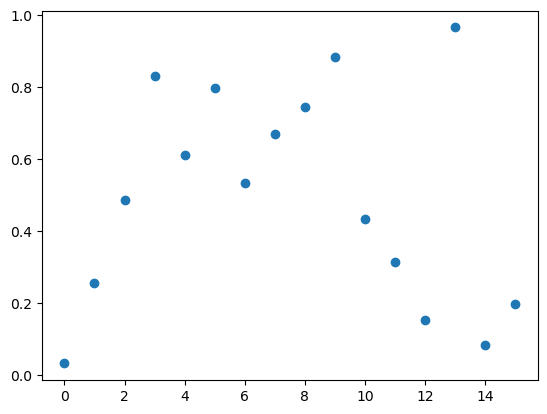

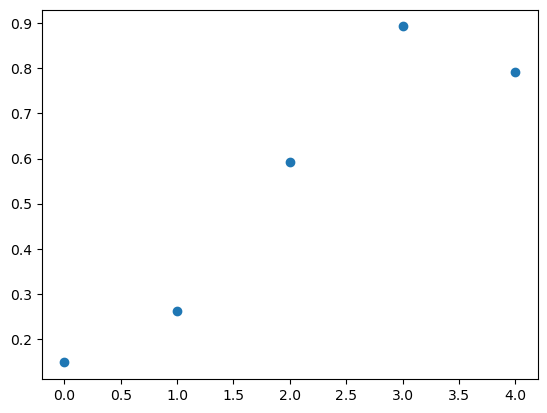

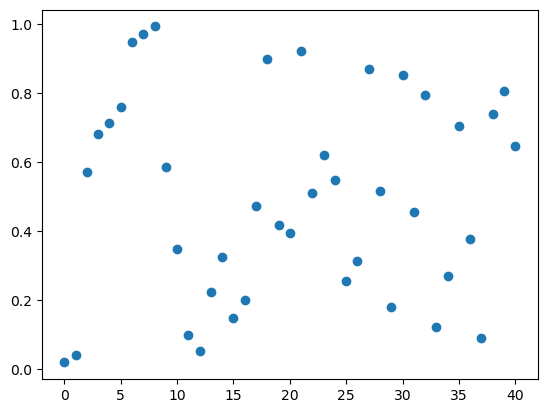

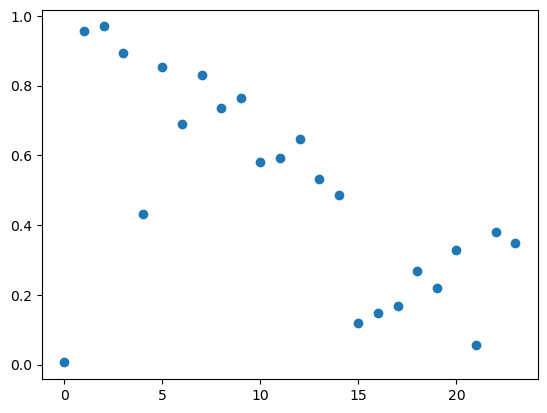

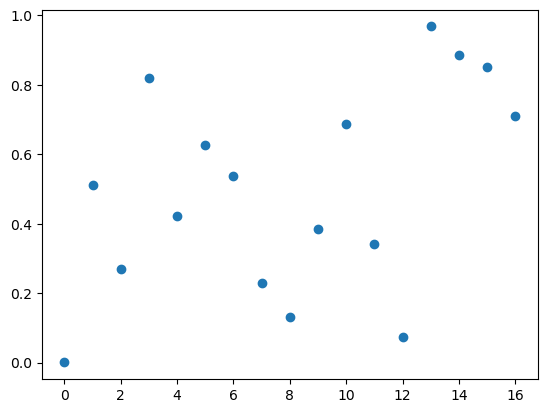

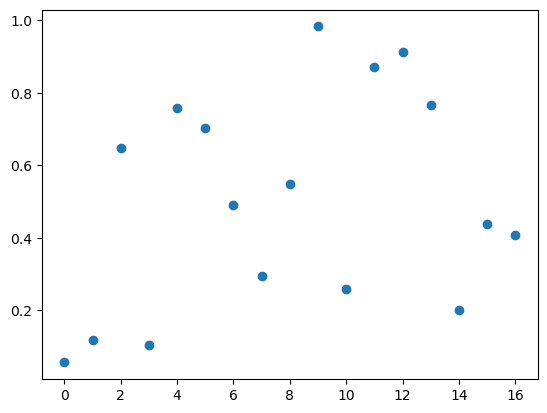

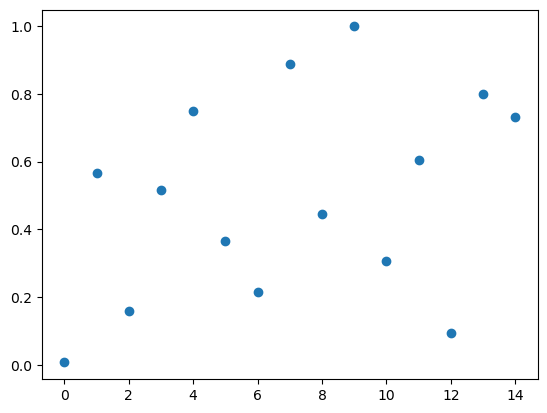

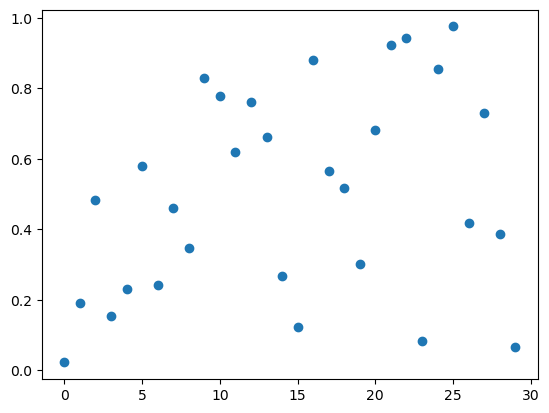

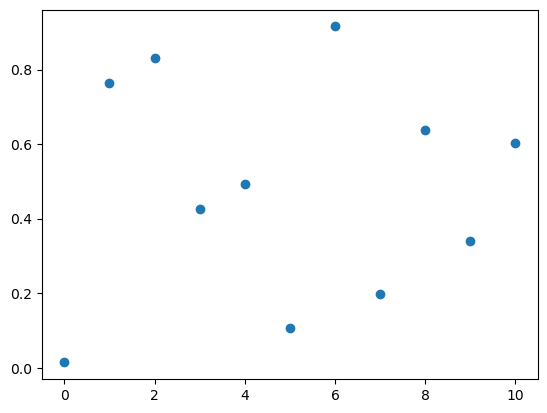

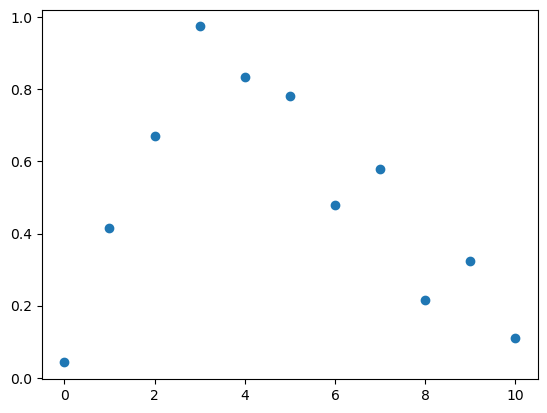

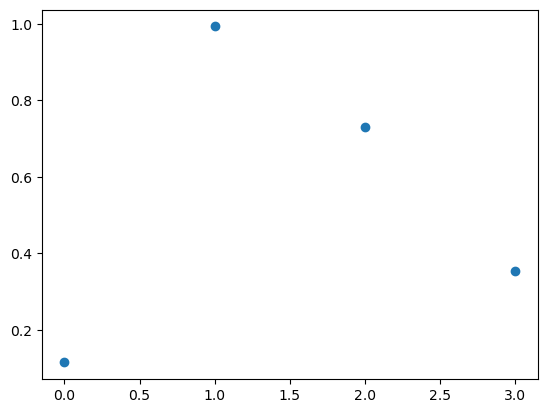

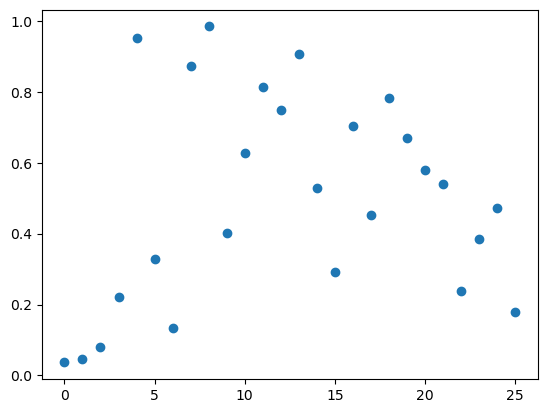

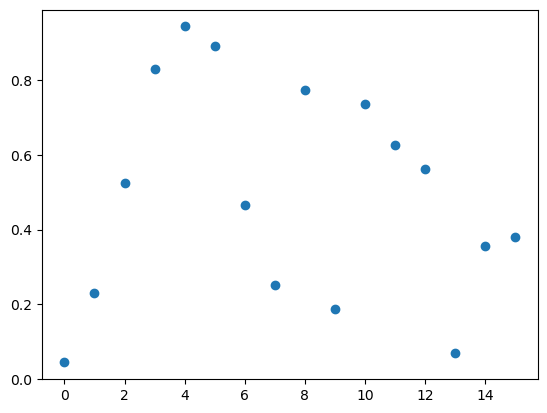

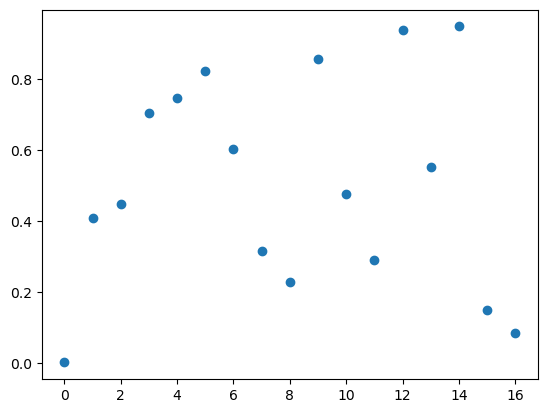

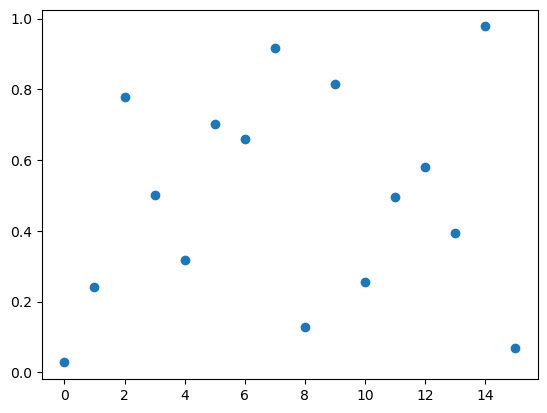

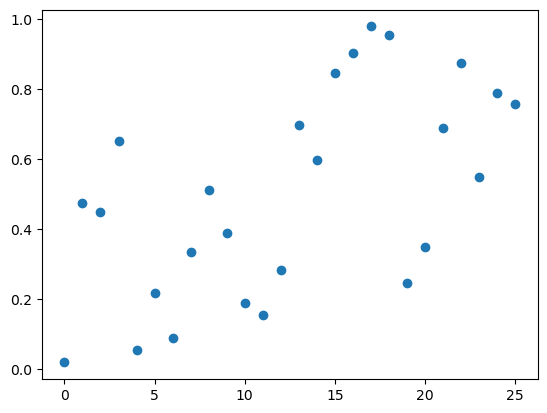

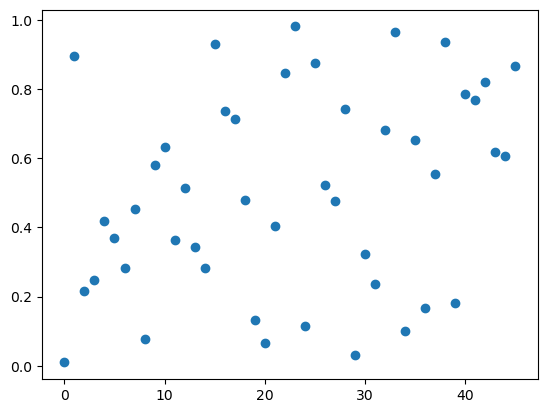

In [9]:
for i in range(0, len(subject_ds)):
    scores_h, scores_s =  conformity_score(subject_ds, i)
    p_values = [conformal_p_value(score, np.array(scores_h)) for score in scores_h]
    plt.scatter(range(0, len(p_values)), p_values)
    plt.show()

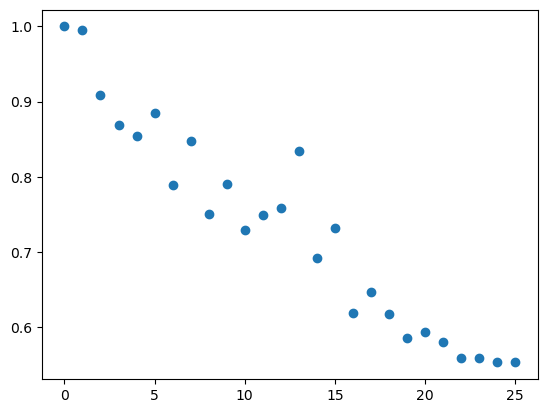

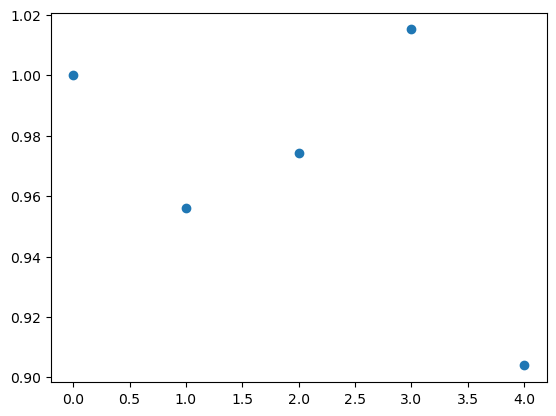

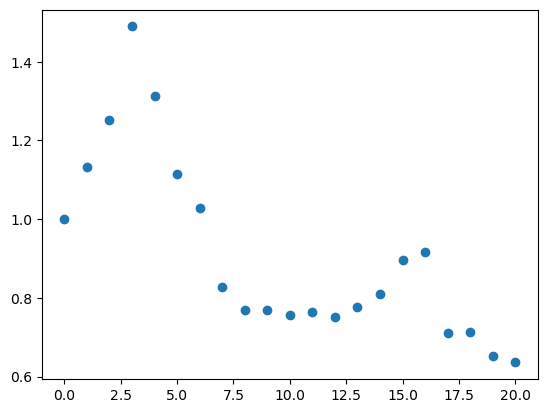

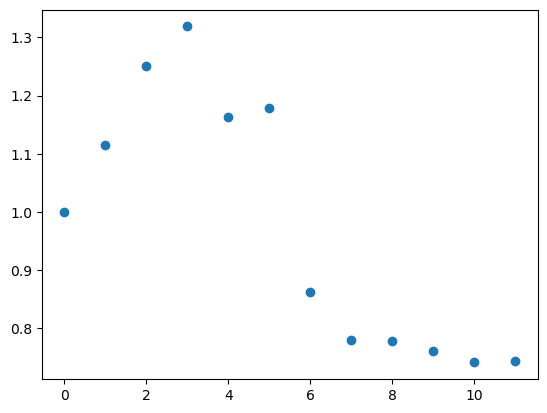

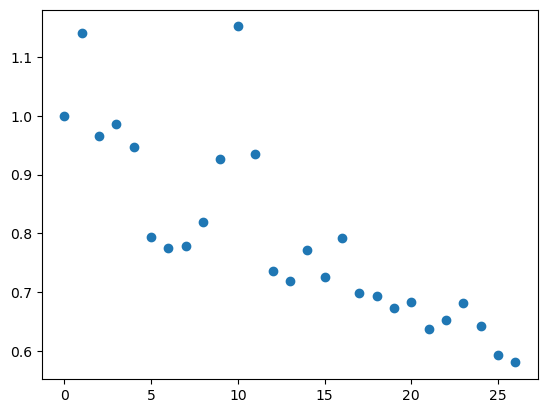

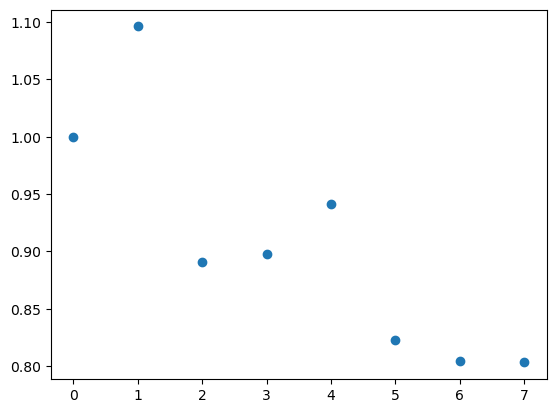

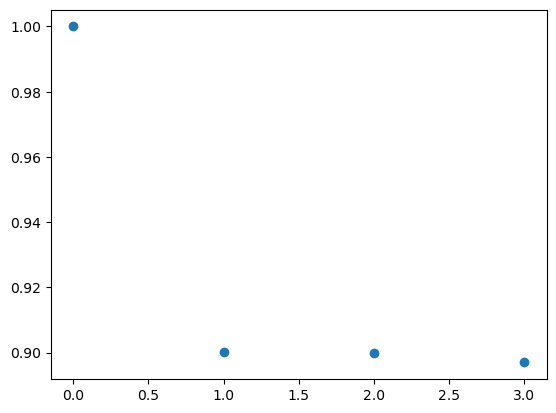

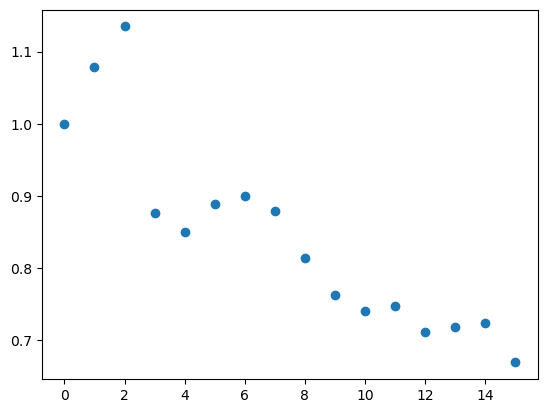

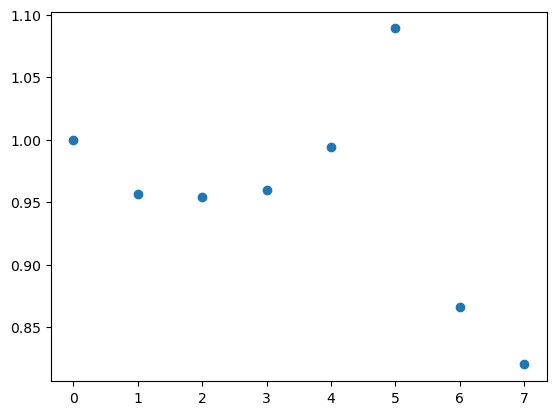

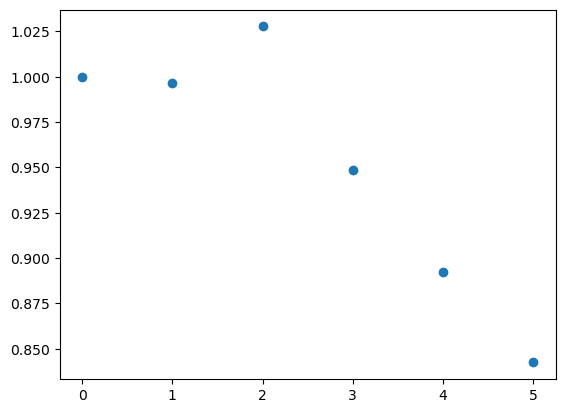

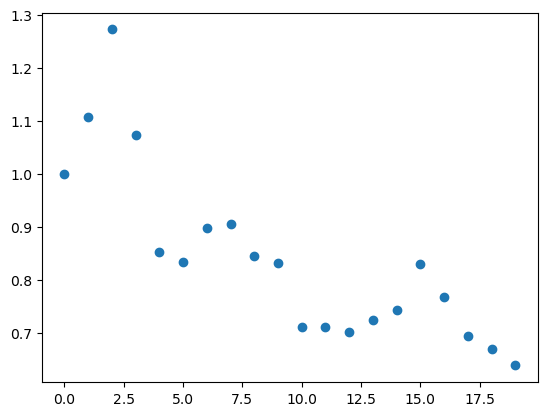

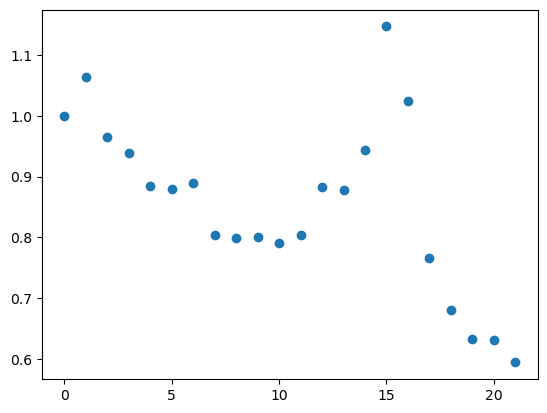

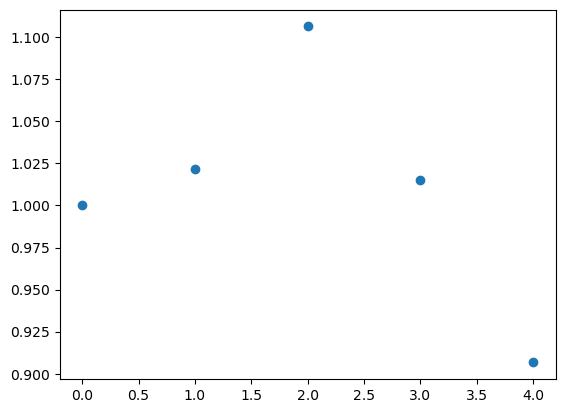

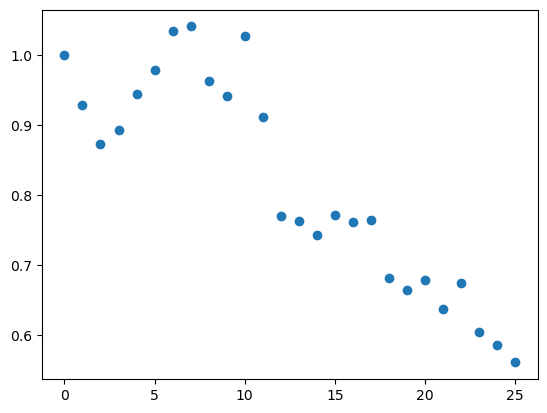

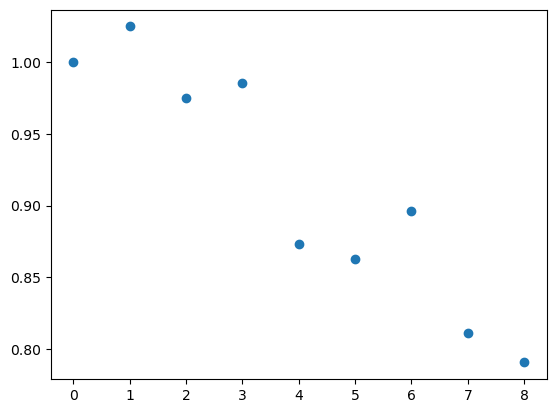

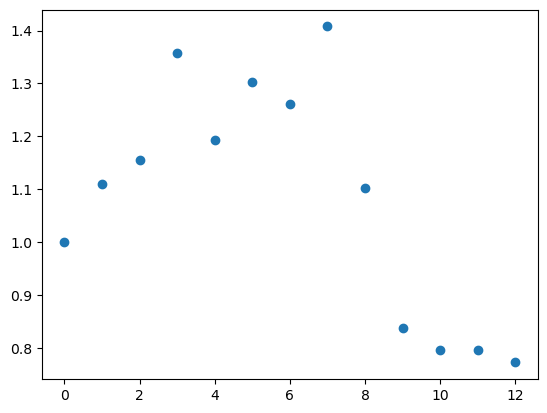

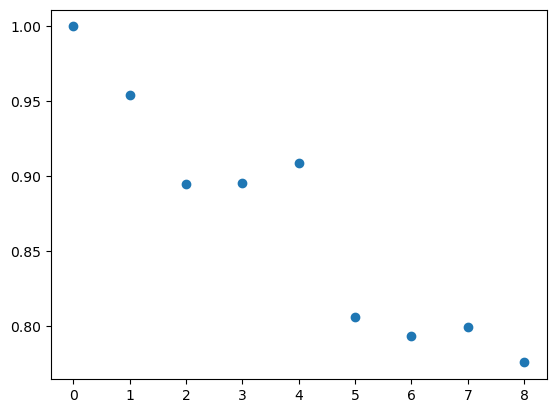

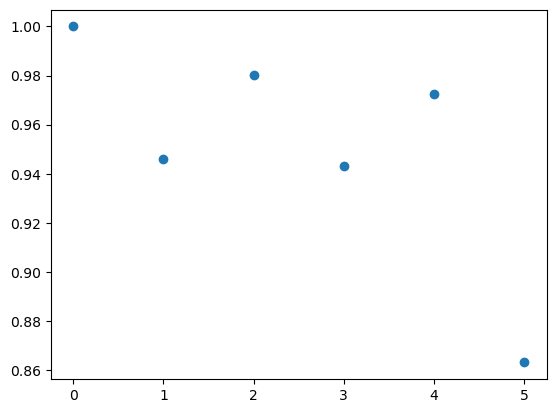

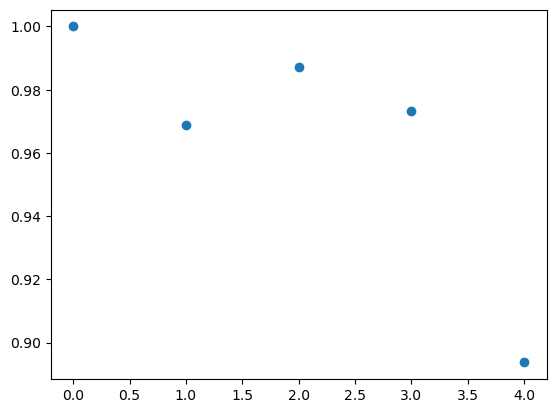

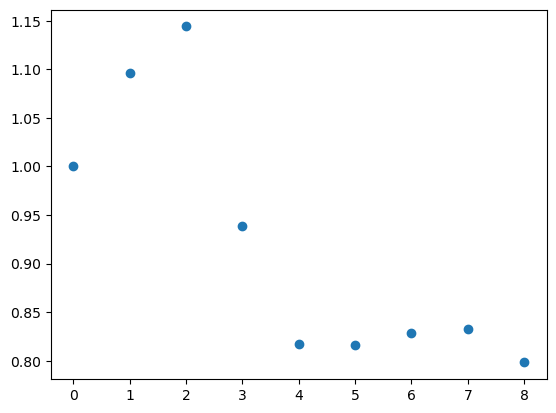

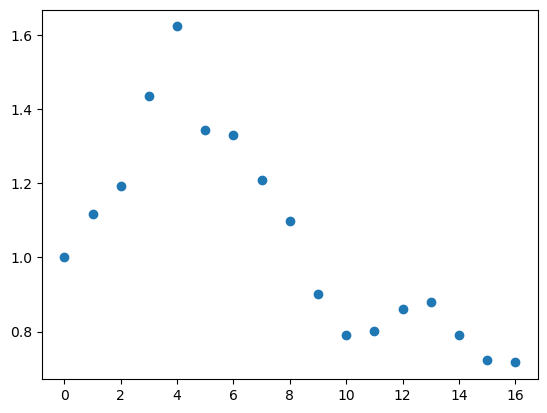

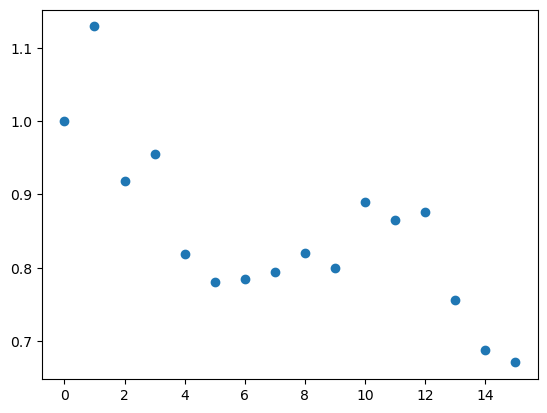

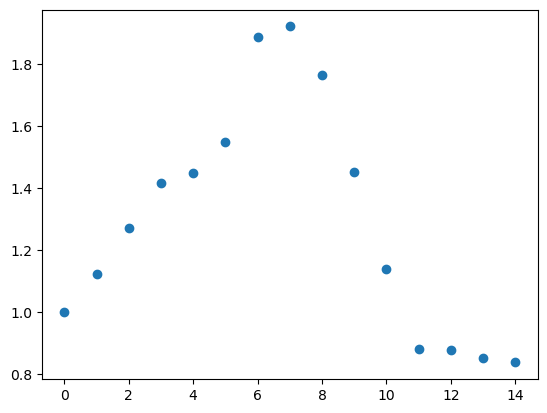

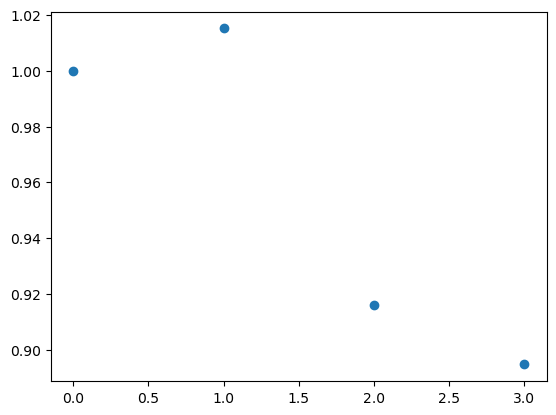

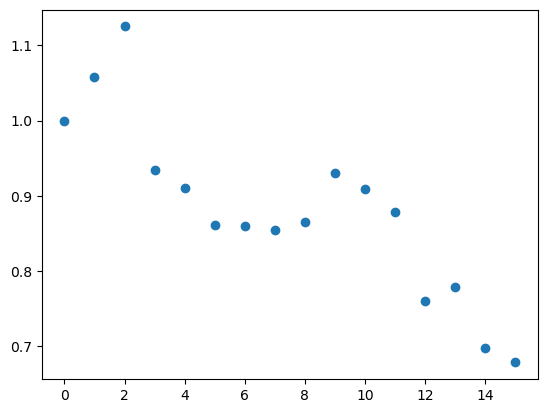

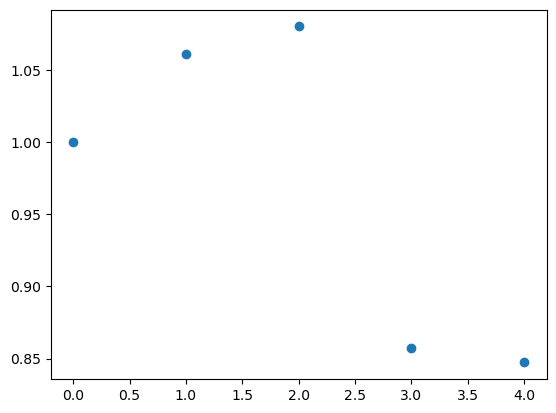

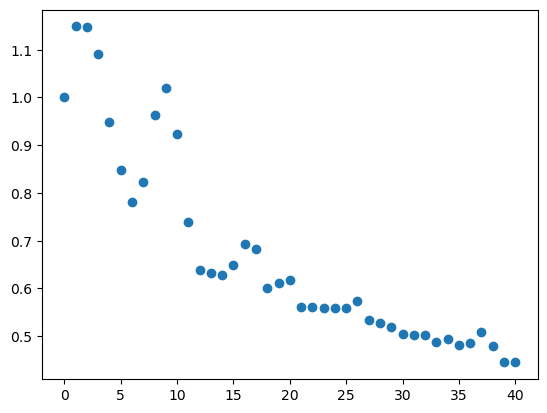

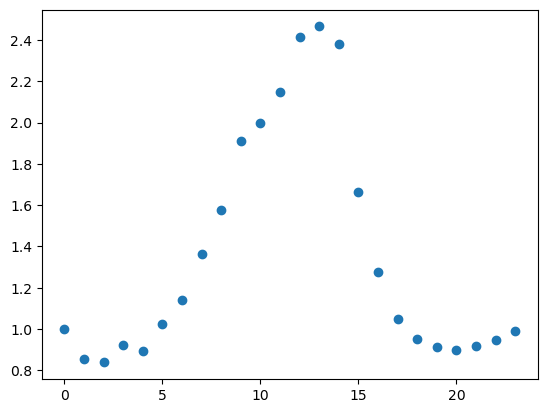

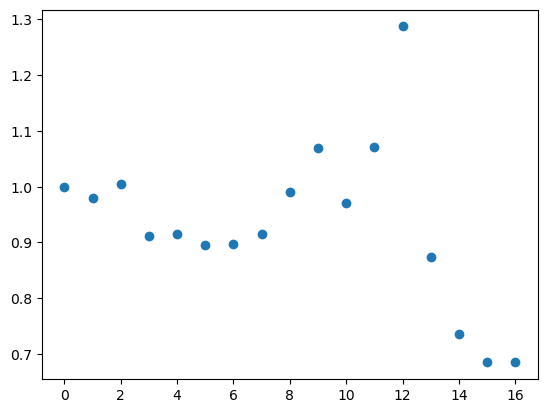

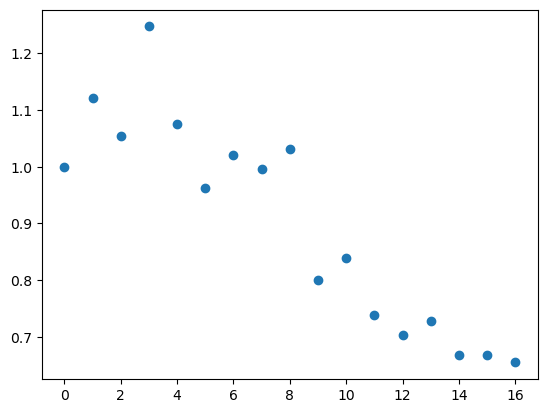

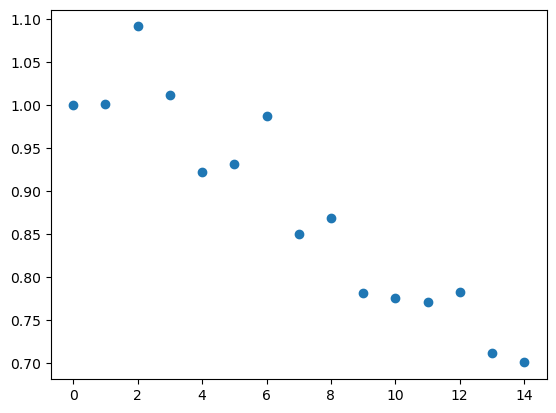

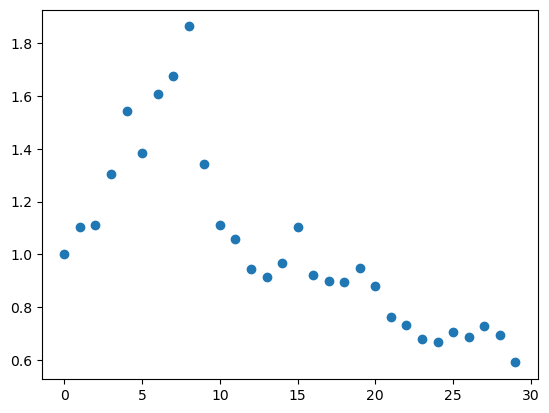

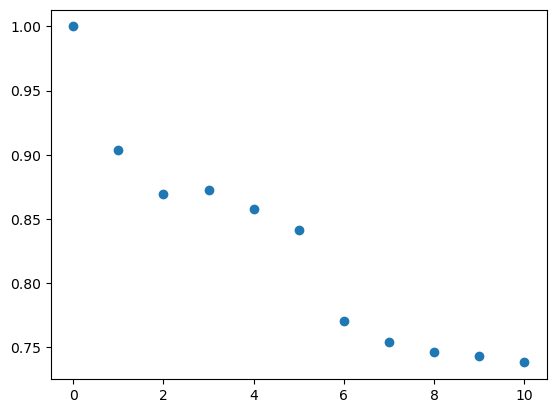

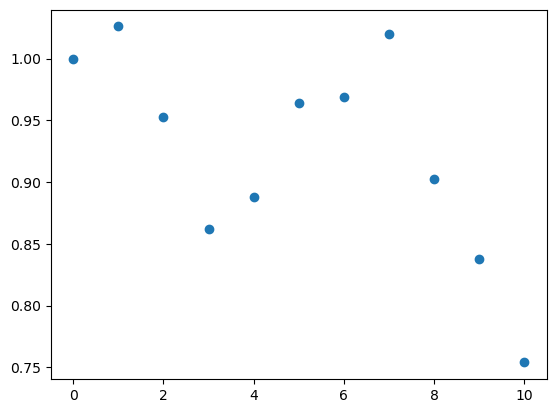

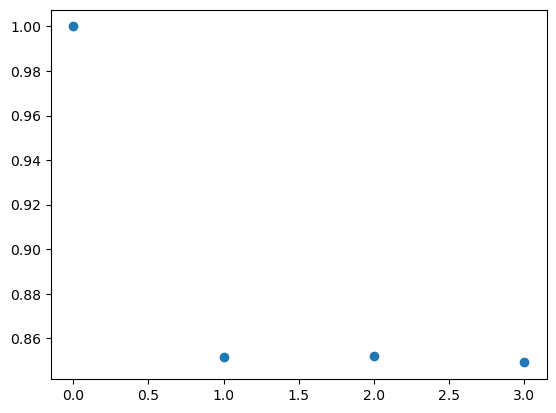

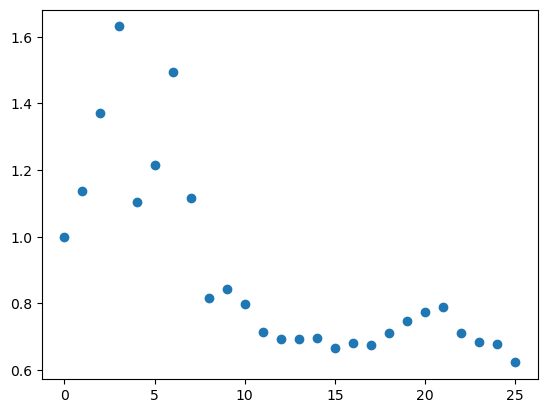

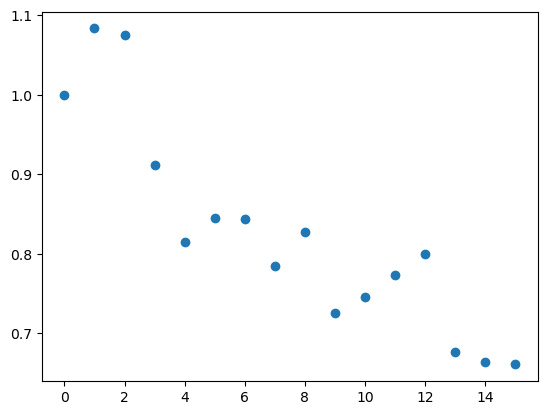

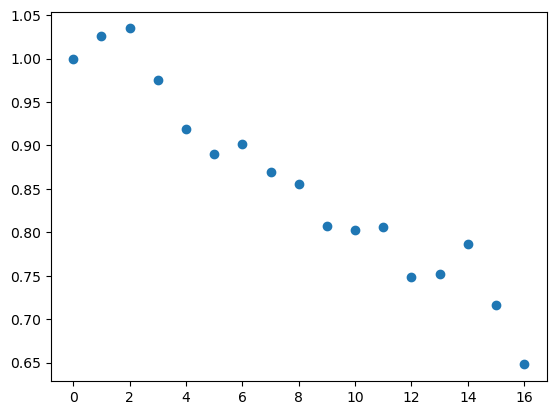

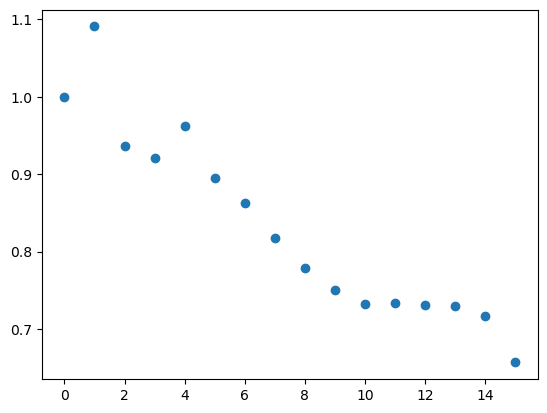

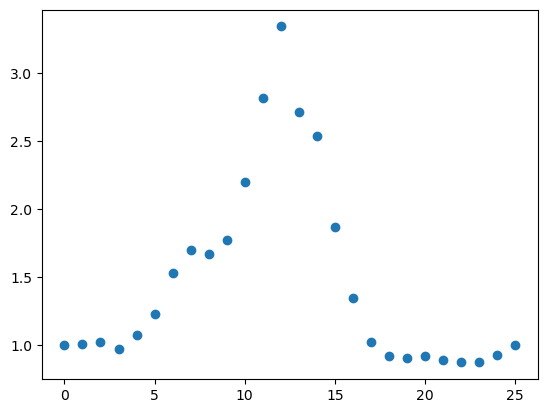

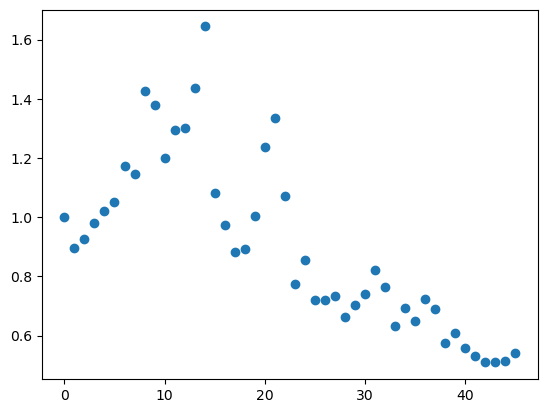

In [52]:
for subject_idx in range(0, len(subject_ds)):

    scores_h, scores_s =  conformity_score(subject_ds, subject_idx)
    p_values = [conformal_p_value(score, np.array(scores_h)) for score in scores_h]
    
    ctm = []
    J = 0.01
    s_0 = 1
    c_neg = 1/3
    c_0 = 1/3
    c_1 = 1/3
    c = 1
    for n in range(0, len(p_values)):
        c_neg = (1-J)*c_neg + (J/3)*c
        c_0 = (1-J)*c_0 + (J/3)*c
        c_1 = (1-J)*c_1 + (J/3)*c
        
        c_neg =  c_neg*(1 + -1 * (p_values[n]-0.5))
        c_0 =  c_0*(1 + 0 * (p_values[n]-0.5))
        c_1 =  c_1*(1 + 1 * (p_values[n]-0.5))
        
        c = c_neg + c_0 + c_1
        ctm.append(c)
        
    plt.scatter(range(0, len(p_values)), ctm)
    plt.show()